## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

In [43]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import mmpretrain
from mmpretrain.apis import init_model




### Define utils

In [44]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(config, chkpt_dir):
    # build model
    model = init_model(config, chkpt_dir)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    y, mask = model.visualize(x.float())
    y = model.head.unpatchify(y)
    # y = y.detach().cpu()
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.head.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.head.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

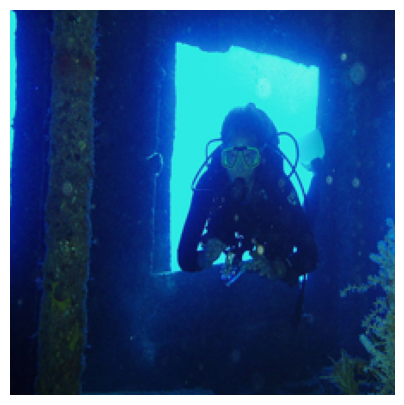

In [45]:
# load an image
# img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img_url = '/scratch/yw6594/hpml/mmpretrain/data/imagenet100/train/n01558993/n01558993_3430.JPEG' # bird
img_url = '/scratch/yw6594/hpml/mmpretrain/data/imagenet1k/train/n10565667/n10565667_603.JPEG' # diver
# img_url = '/scratch/yw6594/hpml/mmpretrain/data/imagenet100/val/n02119022/ILSVRC2012_val_00000517.JPEG' # fox

img = Image.open(img_url)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [46]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = '/scratch/yw6594/hpml/mmpretrain/omit/mae_vit-base-p16_8xb512-coslr-300e-fp16_in1k_20220829-c2cf66ba.pth'
config = '/scratch/yw6594/hpml/mmpretrain/configs_mask/mae/maevit_vis.py'


chkpt_dirhi70 = '/scratch/yw6594/hpml/mmpretrain/out/out/maskout/epoch_70.pth'
chkpt_dirhi50 = '/scratch/yw6594/hpml/mmpretrain/out/out/mask100/epoch_37.pth'
chkpt_dirhi10 = '/scratch/yw6594/hpml/mmpretrain/out/out/maskout/epoch_10.pth'
confighi = '/scratch/yw6594/hpml/mmpretrain/configs_mask/mae/maevithi_vis.py'
model_mae = prepare_model(config, chkpt_dir)
model_maehi7 = prepare_model(confighi, chkpt_dirhi70)
model_maehi5 = prepare_model(confighi, chkpt_dirhi50)
model_maehi10 = prepare_model(confighi, chkpt_dirhi10)
print('Model loaded.')



Loads checkpoint by local backend from path: /scratch/yw6594/hpml/mmpretrain/omit/mae_vit-base-p16_8xb512-coslr-300e-fp16_in1k_20220829-c2cf66ba.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

Loads checkpoint by local backend from path: /scratch/yw6594/hpml/mmpretrain/out/out/maskout/epoch_70.pth
Loads checkpoint by local backend from path: /scratch/yw6594/hpml/mmpretrain/out/out/mask100/epoch_37.pth
Loads checkpoint by local backend from path: /scratch/yw6594/hpml/mmpretrain/out/out/maskout/epoch_10.pth
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


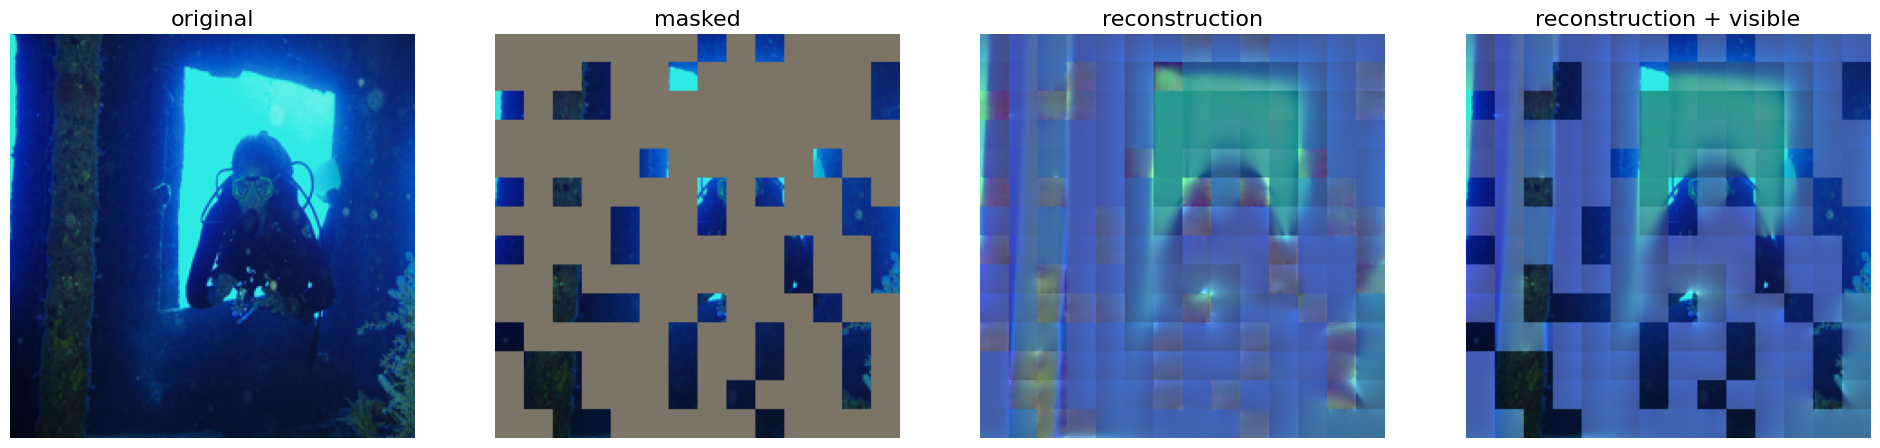

hiMAE 100 with pixel reconstruction-5:


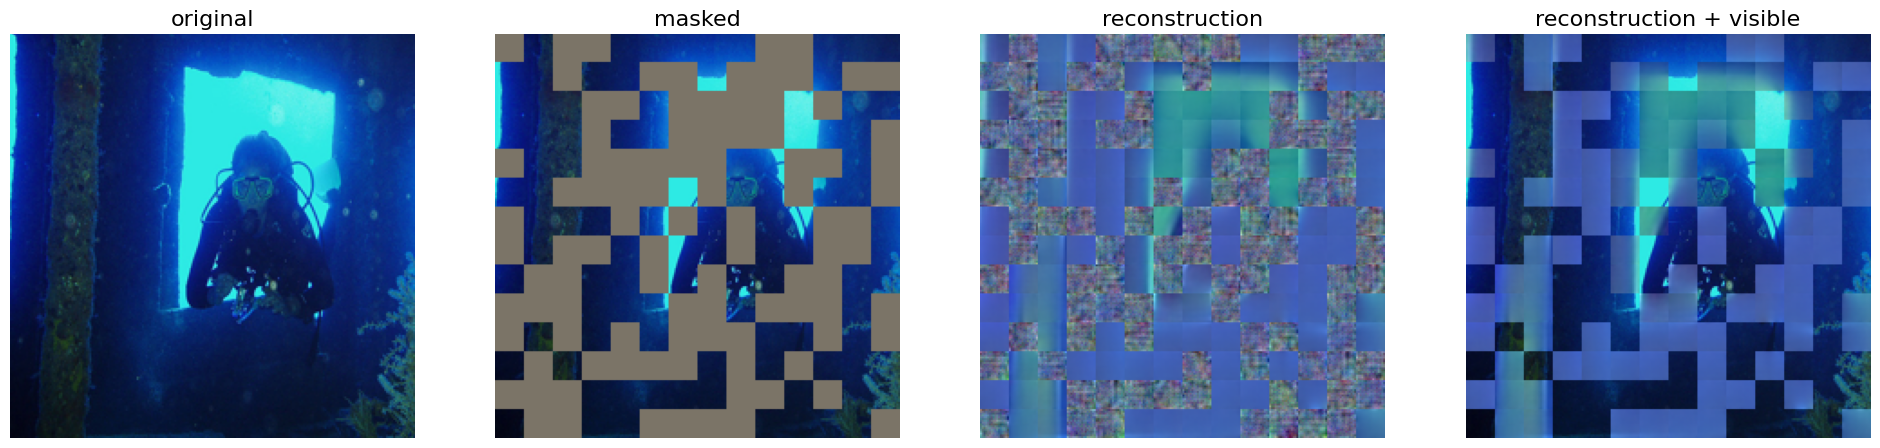

hiMAE with pixel reconstruction-10:


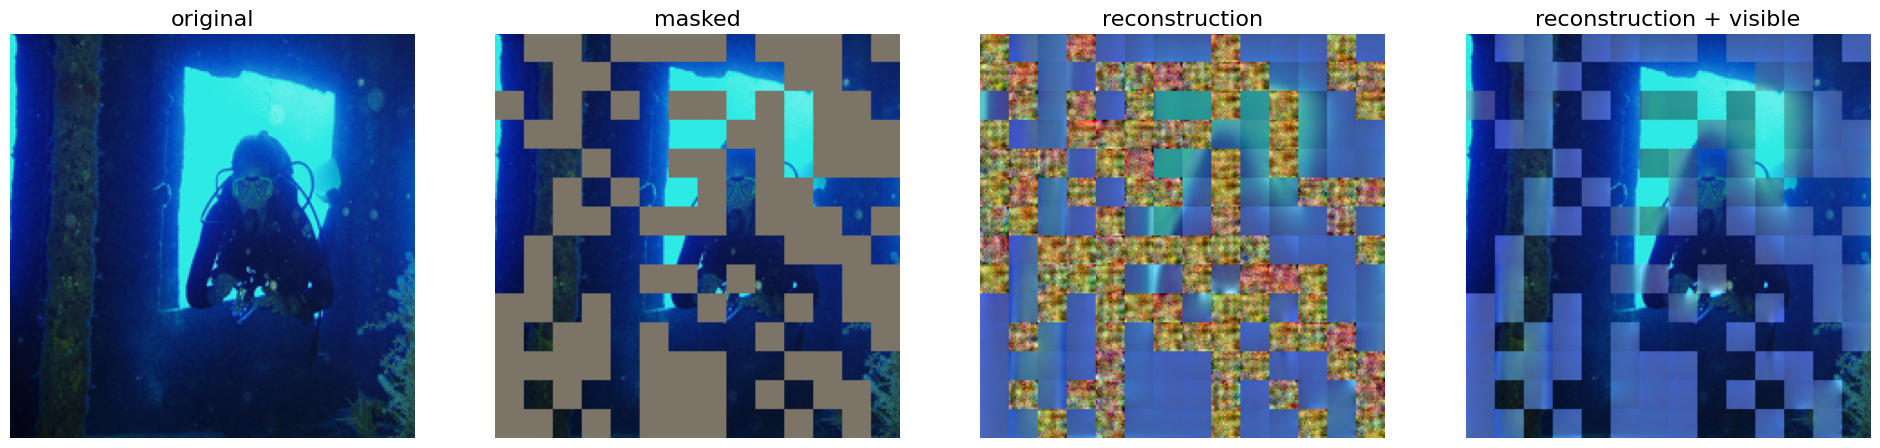

hiMAE with pixel reconstruction-70:


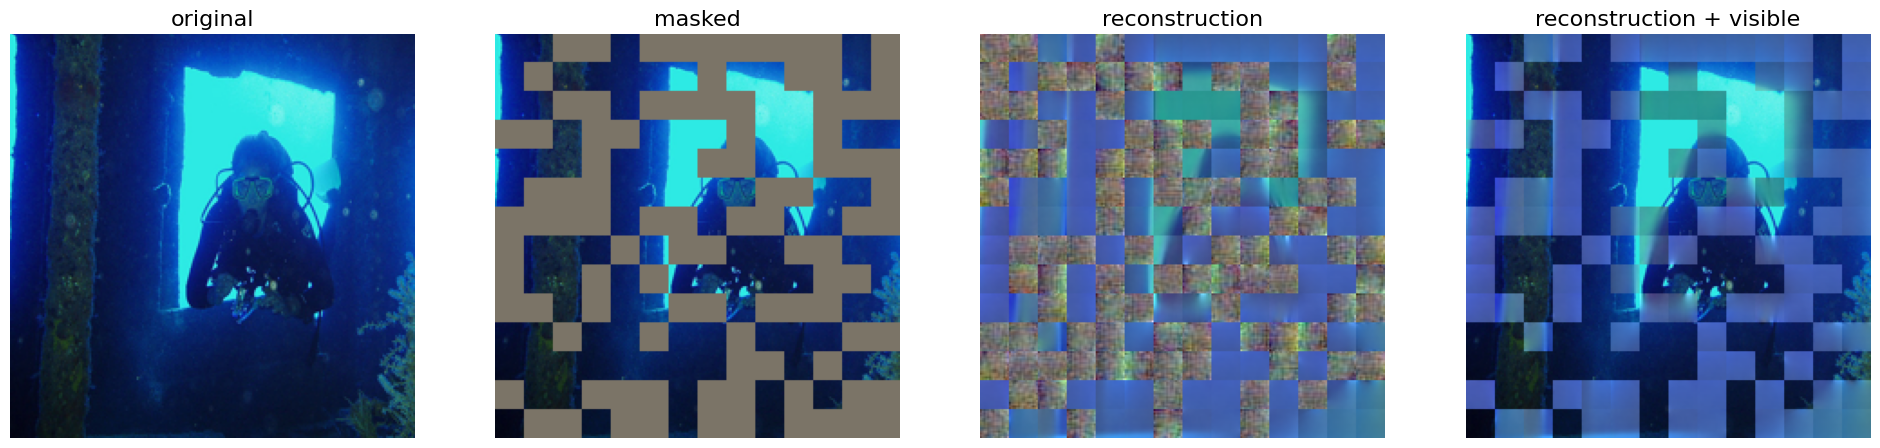

In [47]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

print('hiMAE 100 with pixel reconstruction-5:')
run_one_image(img, model_maehi5)

print('hiMAE with pixel reconstruction-10:')
run_one_image(img, model_maehi10)

print('hiMAE with pixel reconstruction-70:')
run_one_image(img, model_maehi7)

### Load another pre-trained MAE model

In [48]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
# !wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

# chkpt_dir = '/scratch/yw6594/hpml/mmpretrain/omit/mae_vit-base-p16_8xb512-coslr-300e-fp16_in1k_20220829-c2cf66ba.pth'
# config = '/scratch/yw6594/hpml/mmpretrain/configs_mask/mae/maevit_1k.py'
# model_mae = prepare_model(config, chkpt_dir)
# print('Model loaded.')

### Run MAE on the image

In [49]:
# # make random mask reproducible (comment out to make it change)
# torch.manual_seed(2)
# print('MAE with extra GAN loss:')
# run_one_image(img, model_mae_gan)